# Importing Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pipelining and Preprocessing

Note: Train with other type of data also

In [ ]:
from tensorflow.keras.preprocessing import image

import numpy as np
import tensorflow as tf

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

Using Dataset_2 as the main training data for results

In [ ]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Final_Dataset_Augmented_and_mirror_all_new/'

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
img_data_list = []
image_path_list = []

In [ ]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

  3%|▎         | 27/1000 [00:00<00:03, 259.65it/s]

Loading the images of dataset - Covid-19



  3%|▎         | 27/1000 [00:00<00:03, 263.31it/s]

Loading the images of dataset - Normal



  3%|▎         | 29/1000 [00:00<00:03, 288.66it/s]

Loading the images of dataset - Pneumonia



 78%|███████▊  | 781/1000 [00:02<00:00, 265.60it/s]


In [ ]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(2400, 224, 224, 3)


In [ ]:
len(image_path_list)

2400

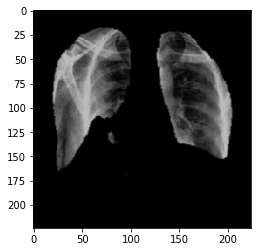

In [ ]:
plt.imshow(img_data[500])

In [ ]:
img_data.dtype

dtype('int32')

# Neural Network Training

Note: use other networks also

## Data Preprocessing 

In [ ]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [ ]:
labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
labels.shape

(2400,)

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)

#X_model, X_test,Y_model, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [ ]:
X_test_NN.shape

(480, 224, 224, 3)

In [ ]:
X_train_NN.shape

(1920, 224, 224, 3)

In [ ]:
y_train_NN.shape

(1920, 3)

## Training

90

In [ ]:
import tensorflow as tf
# shape 224, 224, 3

In [ ]:
DenseNet201 = tf.keras.applications.DenseNet201(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

In [ ]:
DenseNet169.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model
last_layer = DenseNet201.get_layer('avg_pool').output
x = Dense(1024, activation='relu', name='fc1')(last_layer)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(256, activation='relu', name='fc3')(x)
out = Dense(num_classes, activation = 'softmax', name = 'output')(x)
custom_model = Model(DenseNet201.input, out)

In [ ]:
for layer in custom_model.layers[:-4]:
    layer.trainable = False

In [ ]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [ ]:
custom_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [ ]:
custom_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
X_train_pp = preprocess_input(X_train_NN)
X_test_pp = preprocess_input(X_test_NN)
#X_test = preprocess_input(X_test)

In [ ]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('DenseNet201.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [ ]:
custom_model.fit(X_train_pp, y_train_NN, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_pp, y_test_NN), callbacks = callbacks)

Epoch 1/100
60/60 [==============================] - 28s 465ms/step - loss: 0.4222 - accuracy: 0.8302 - val_loss: 0.2068 - val_accuracy: 0.9292
Epoch 2/100
60/60 [==============================] - 25s 413ms/step - loss: 0.1857 - accuracy: 0.9276 - val_loss: 0.1272 - val_accuracy: 0.9521
Epoch 3/100
60/60 [==============================] - 25s 408ms/step - loss: 0.1246 - accuracy: 0.9552 - val_loss: 0.1127 - val_accuracy: 0.9708
Epoch 4/100
60/60 [==============================] - 23s 384ms/step - loss: 0.1063 - accuracy: 0.9609 - val_loss: 0.1216 - val_accuracy: 0.9521
Epoch 5/100
60/60 [==============================] - 23s 386ms/step - loss: 0.0702 - accuracy: 0.9755 - val_loss: 0.1446 - val_accuracy: 0.9521
Epoch 6/100
60/60 [==============================] - 23s 383ms/step - loss: 0.0756 - accuracy: 0.9698 - val_loss: 0.1268 - val_accuracy: 0.9500
Epoch 7/100
60/60 [==============================] - 23s 384ms/step - loss: 0.0733 - accuracy: 0.9724 - val_loss: 0.3305 - val_accuracy:

In [ ]:
classifier = tf.keras.models.load_model("DenseNet201.h5")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = classifier.predict(X_test_pp)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_NN,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[161   0   0]
 [  0 162   5]
 [  0   4 148]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       0.98      0.97      0.97       167
           2       0.97      0.97      0.97       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



###Testing the model with ML techniques

In [ ]:
classifier = tf.keras.models.load_model("DenseNet201.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [ ]:
Model_new.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
x_new,y_new = shuffle(img_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.1, random_state = 2)

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
X_train_1 = preprocess_input(X_train_1)
X_test_1 = preprocess_input(X_test_1)

In [ ]:
y_train_1.shape

(2160,)

In [ ]:
train_new = Model_new.predict(X_train_1)
test_new = Model_new.predict(X_test_1)
print(test_new)

[[0.         0.         0.         ... 4.155376   0.8428033  1.171902  ]
 [0.         0.09199585 0.         ... 2.9934719  0.77847445 1.3966037 ]
 [0.         0.         0.         ... 5.207101   0.32967302 1.6209844 ]
 ...
 [0.         2.0262887  0.         ... 0.         2.349714   2.5378058 ]
 [0.         0.         0.         ... 5.7754316  0.21191207 1.6934878 ]
 [0.         3.8587496  0.         ... 4.2246246  0.         0.        ]]


In [ ]:
test_new.shape

(240, 256)

#### svm

94 and 90

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', max_iter = 50000)

svm.fit(train_new,y_train_1)
print('fitting done !!!')
svm.score(train_new,y_train_1)

fitting done !!!


0.9981481481481481

fc3

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83  0  0]
 [ 0 88  5]
 [ 0  0 64]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      0.95      0.97        93
           2       0.93      1.00      0.96        64

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



#### xg_boost

92 and 91

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

xb.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83  0  0]
 [ 0 87  6]
 [ 0  0 64]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      0.94      0.97        93
           2       0.91      1.00      0.96        64

    accuracy                           0.97       240
   macro avg       0.97      0.98      0.97       240
weighted avg       0.98      0.97      0.98       240



#### random forest

93 and 90

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=2000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

rf.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83  0  0]
 [ 0 88  5]
 [ 0  0 64]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      0.95      0.97        93
           2       0.93      1.00      0.96        64

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



# Descriptors Extraction and Training

## Preprocessing the Data

In [ ]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

Using: SIFT

In [ ]:
import cv2

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [ ]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 2400/2400 [00:59<00:00, 40.44it/s]


In [ ]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

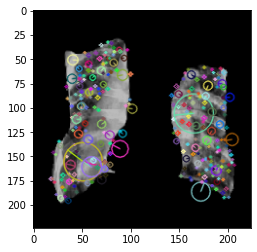

In [ ]:
plt.imshow(image)
plt.show()

Using BRISK

In [ ]:
import cv2

In [ ]:
brisk = cv2.BRISK_create(50)
des_list = []

In [ ]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 2400/2400 [00:11<00:00, 212.68it/s]


In [ ]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

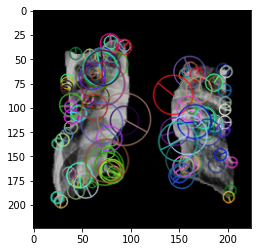

In [ ]:
plt.imshow(image)
plt.show()

stacking all the descriptors vertically in a numpy array

In [ ]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 2400/2400 [00:04<00:00, 571.60it/s]


In [ ]:
descriptors_float = descriptors.astype(float)

Clustring using k means

Note: use others methods also

In [ ]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

calculating the histogram of the features and representing them as vectors.

vq(vector quantization) Assigns codes from a code book to observations.

In [ ]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 2400/2400 [00:02<00:00, 1185.25it/s]


performing Tf-Idf vectorization

In [ ]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

Scaling the words

Standardize features by removing the mean and scaling to unit variance

In a way normalizarion

In [ ]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [ ]:
im_features.shape

(2400, 128)

In [ ]:
im_features.dtype

dtype('float32')

In [ ]:
im_features

array([[-0.46510828, -0.70773184, -0.71588826, ..., -0.32520464,
         0.26811704, -0.32282335],
       [ 2.4192843 ,  1.352373  ,  1.0832026 , ...,  2.4424944 ,
         0.26811704,  3.981488  ],
       [ 3.8614805 , -0.70773184,  0.18365718, ...,  1.5199281 ,
         0.26811704,  1.3989012 ],
       ...,
       [-0.46510828, -0.70773184, -0.71588826, ..., -0.32520464,
        -0.7203328 , -0.32282335],
       [-0.46510828,  0.32232058, -0.71588826, ..., -0.32520464,
         3.2334666 , -0.32282335],
       [-0.46510828,  0.32232058, -0.71588826, ...,  1.5199281 ,
        -0.7203328 ,  0.5380389 ]], dtype=float32)

## Train and Test spliting 

In [ ]:
num_classes = 3
num_of_samples = im_features.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
x,y = shuffle(im_features,labels, random_state=2)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x, y, test_size = 0.15, random_state = 2)

In [ ]:
X_train_d.shape

(2040, 128)

In [ ]:
y_train_d.shape

(2040,)

## Training with SIFT

### Training on SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(X_train_d,y_train_d)

0.9416666666666667

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[104   1  13]
 [  0 121  16]
 [ 14   7  84]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       118
           1       0.94      0.88      0.91       137
           2       0.74      0.80      0.77       105

    accuracy                           0.86       360
   macro avg       0.85      0.85      0.85       360
weighted avg       0.86      0.86      0.86       360



### Training on XG_boost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(X_train_d,y_train_d)

0.9303921568627451

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[102   3  13]
 [  1 124  12]
 [ 13  10  82]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       118
           1       0.91      0.91      0.91       137
           2       0.77      0.78      0.77       105

    accuracy                           0.86       360
   macro avg       0.85      0.85      0.85       360
weighted avg       0.86      0.86      0.86       360



### Training on Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [ ]:
rf.score(X_train_d,y_train_d)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 93   5  20]
 [  0 124  13]
 [ 11  13  81]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       118
           1       0.87      0.91      0.89       137
           2       0.71      0.77      0.74       105

    accuracy                           0.83       360
   macro avg       0.83      0.82      0.82       360
weighted avg       0.83      0.83      0.83       360



## Training with BRISK

### Training on SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(X_train_d,y_train_d)

0.8686274509803922

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 84   9  25]
 [  2 108  27]
 [ 11   9  85]]
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       118
           1       0.86      0.79      0.82       137
           2       0.62      0.81      0.70       105

    accuracy                           0.77       360
   macro avg       0.78      0.77      0.77       360
weighted avg       0.79      0.77      0.77       360



### Training on XG_boost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(X_train_d,y_train_d)

0.8642156862745098

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 82  10  26]
 [  3 104  30]
 [ 13  16  76]]
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       118
           1       0.80      0.76      0.78       137
           2       0.58      0.72      0.64       105

    accuracy                           0.73       360
   macro avg       0.74      0.73      0.73       360
weighted avg       0.75      0.73      0.73       360



### Training on Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [ ]:
rf.score(X_train_d,y_train_d)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 83   9  26]
 [  3 102  32]
 [ 13  14  78]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       118
           1       0.82      0.74      0.78       137
           2       0.57      0.74      0.65       105

    accuracy                           0.73       360
   macro avg       0.74      0.73      0.73       360
weighted avg       0.75      0.73      0.74       360



# Combining all the Processes

In [ ]:
import tensorflow as tf

In [ ]:
Model_s = tf.keras.models.load_model("DenseNet201.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [ ]:
Model_C.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
img_data = preprocess_input(img_data)

In [ ]:
Pred_fc3 = Model_C.predict(img_data)

In [ ]:
Pred_fc3.shape

(2400, 256)

In [ ]:
Pred_fc3.dtype

dtype('float32')

In [ ]:
type(Pred_fc3)

numpy.ndarray

also using the extracted features using opencv

In [ ]:
im_features.shape

(2400, 128)

In [ ]:
im_features.dtype

dtype('float32')

In [ ]:
type(im_features)

numpy.ndarray

combining the data from pred_fc3 and im_features

In [ ]:
total_features = 384

In [ ]:
total_dataset = 2400

In [ ]:
feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

In [ ]:
feature_data.shape

(2400, 384)

In [ ]:
for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 2400/2400 [00:00<00:00, 100200.37it/s]


In [ ]:
feature_data

array([[-0.46510828, -0.70773184, -0.71588826, ...,  7.110533  ,
         0.        ,  1.1807796 ],
       [ 2.4192843 ,  1.352373  ,  1.0832026 , ...,  8.536204  ,
         0.        ,  1.800979  ],
       [ 3.8614805 , -0.70773184,  0.18365718, ...,  6.958515  ,
         0.        ,  0.6659548 ],
       ...,
       [-0.46510828, -0.70773184, -0.71588826, ...,  0.        ,
         2.398383  ,  2.6098301 ],
       [-0.46510828,  0.32232058, -0.71588826, ...,  0.        ,
         3.5631275 ,  3.6700644 ],
       [-0.46510828,  0.32232058, -0.71588826, ...,  0.        ,
         1.974976  ,  1.9361001 ]], dtype=float32)

Train Test split

change accordance to the type of training

In [ ]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

Use Different Train Test Splitting --> 0.05, 0.1, 0.2, 0.3

In [ ]:
# use the following line training the Deep learning Model
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(feature_data,Y, random_state=2)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [ ]:
X_train_c.shape

(1920, 384)

In [ ]:
y_train_c.shape

(1920, 3)

## Training DL model

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model_combined = Sequential()
model_combined.add(Dense(1024, input_dim=384, activation='relu', name='dense_1'))
model_combined.add(Dense(800, activation='relu', name='dense_2'))
model_combined.add(Dense(512, activation='relu', name='dense_3'))
model_combined.add(Dense(300, activation='relu', name='dense_4'))
model_combined.add(Dense(256, activation='relu', name='dense_5'))
model_combined.add(Dense(128, activation='relu', name='dense_6'))
model_combined.add(Dense(3, activation='softmax', name = 'output_layer'))

In [ ]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [ ]:
model_combined.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

make wider, make deeper, make wider and deeper, and also use other methods

In [ ]:
model_combined.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 3)                

In [ ]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('DenseNet201_combined_BRISK.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [ ]:
model_combined.fit(X_train_c, y_train_c, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_c, y_test_c), callbacks = callbacks)

Epoch 1/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0261 - accuracy: 0.9885 - val_loss: 0.6397 - val_accuracy: 0.9708
Epoch 2/100
60/60 [==============================] - 0s 7ms/step - loss: 6.3330e-09 - accuracy: 1.0000 - val_loss: 0.6450 - val_accuracy: 0.9708
Epoch 3/100
60/60 [==============================] - 0s 7ms/step - loss: 3.0423e-09 - accuracy: 1.0000 - val_loss: 0.6449 - val_accuracy: 0.9729
Epoch 4/100
60/60 [==============================] - 0s 7ms/step - loss: 1.9247e-09 - accuracy: 1.0000 - val_loss: 0.6447 - val_accuracy: 0.9729
Epoch 5/100
60/60 [==============================] - 0s 6ms/step - loss: 1.3038e-09 - accuracy: 1.0000 - val_loss: 0.6446 - val_accuracy: 0.9729
Epoch 6/100
60/60 [==============================] - 0s 7ms/step - loss: 9.9341e-10 - accuracy: 1.0000 - val_loss: 0.6445 - val_accuracy: 0.9729
Epoch 7/100
60/60 [==============================] - 0s 6ms/step - loss: 8.0715e-10 - accuracy: 1.0000 - val_loss: 0.6444 - val_accur

In [ ]:
Model_n = tf.keras.models.load_model("DenseNet201_combined_BRISK.h5")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_c)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_c,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[161   0   0]
 [  0 162   5]
 [  0   9 143]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       0.95      0.97      0.96       167
           2       0.97      0.94      0.95       152

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



SIFT ACCURACY was 98%

## Using ML methods

In [ ]:
Model_n = tf.keras.models.load_model("DenseNet201_combined_BRISK.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [ ]:
Model_csn.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   [(None, 384)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)             

In [ ]:
x_new,y_new = shuffle(feature_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.2, random_state = 2)

In [ ]:
train_new = Model_csn.predict(X_train_1)
test_new = Model_csn.predict(X_test_1)
print(test_new)

[[ 0.26703587  0.08916601  0.         ... 16.732416    0.
   5.874447  ]
 [ 0.5949313   0.50207996  0.         ... 12.513974    0.
   4.7167115 ]
 [ 0.28806594  0.31798008  0.         ... 20.94504     0.
   7.5851707 ]
 ...
 [ 0.          6.6052303   0.         ... 40.13701     0.
   0.        ]
 [ 0.          0.          0.         ... 28.069742    0.
   9.789645  ]
 [ 0.          0.          0.         ... 26.472675    0.
   8.924239  ]]


###Results With SIFT - Scale Invarient Feature Transform

#### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(train_new, y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[160   0   1]
 [  0 162   5]
 [  0   3 149]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       161
           1       0.98      0.97      0.98       167
           2       0.96      0.98      0.97       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



#### xg_boost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(train_new,y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[160   0   1]
 [  1 160   6]
 [  0   3 149]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       161
           1       0.98      0.96      0.97       167
           2       0.96      0.98      0.97       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



#### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [ ]:
rf.score(train_new,y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[160   0   1]
 [  0 162   5]
 [  0   3 149]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       161
           1       0.98      0.97      0.98       167
           2       0.96      0.98      0.97       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



###Results With BRISK - Binary Robust Invarient Scalable Keypoints

#### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(train_new, y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 162   5]
 [  0   4 148]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       0.98      0.97      0.97       167
           2       0.97      0.97      0.97       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



#### xg_boost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(train_new,y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[159   0   2]
 [  0 162   5]
 [  0   9 143]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       161
           1       0.95      0.97      0.96       167
           2       0.95      0.94      0.95       152

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



#### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [ ]:
rf.score(train_new,y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 162   5]
 [  0   6 146]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       0.96      0.97      0.97       167
           2       0.97      0.96      0.96       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



# Testing the models

## Dataset Preprocessing

In [ ]:
from tensorflow.keras.preprocessing import image

import numpy as np

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm
import tensorflow as tf


In [ ]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Testing_Dataset/'

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
img_data_list = []
image_path_list = []

In [ ]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

 34%|███▍      | 31/91 [00:00<00:00, 304.03it/s]

Loading the images of dataset - Covid-19



 35%|███▌      | 32/91 [00:00<00:00, 315.50it/s]

Loading the images of dataset - Normal



 33%|███▎      | 32/97 [00:00<00:00, 315.25it/s]

Loading the images of dataset - Pneumonia



100%|██████████| 97/97 [00:00<00:00, 306.09it/s]


In [ ]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(279, 224, 224, 3)


In [ ]:
len(image_path_list)

279

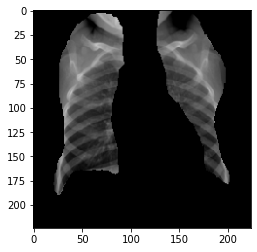

In [ ]:
plt.imshow(img_data[100])

In [ ]:
img_data.dtype

dtype('int32')

In [ ]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [ ]:
labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
labels.shape

(279,)

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

X_test,Y_test = shuffle(img_data,Y, random_state=2)

## Simple Model

In [ ]:
Model_n = tf.keras.models.load_model("DenseNet201.h5")

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
X_test = preprocess_input(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[91  0  0]
 [91  0  0]
 [97  0  0]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.33      1.00      0.49        91
           1       0.00      0.00      0.00        91
           2       0.00      0.00      0.00        97

    accuracy                           0.33       279
   macro avg       0.11      0.33      0.16       279
weighted avg       0.11      0.33      0.16       279



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


actually 92%

ML Techniques

In [ ]:
classifier = tf.keras.models.load_model("DenseNet201.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [ ]:
x_test_new,y_test_new = shuffle(img_data,labels, random_state=2)

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
x_test_new = preprocess_input(x_test_new)

In [ ]:
test_new_x = Model_new.predict(x_test_new)

svm

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[88  0  3]
 [ 0 81 10]
 [ 2  8 87]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        91
           1       0.91      0.89      0.90        91
           2       0.87      0.90      0.88        97

    accuracy                           0.92       279
   macro avg       0.92      0.92      0.92       279
weighted avg       0.92      0.92      0.92       279



xg_boost

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 0 80 11]
 [ 2  7 88]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        91
           1       0.92      0.88      0.90        91
           2       0.88      0.91      0.89        97

    accuracy                           0.92       279
   macro avg       0.93      0.93      0.93       279
weighted avg       0.92      0.92      0.92       279



random_forest

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[88  0  3]
 [ 0 80 11]
 [ 2  8 87]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        91
           1       0.91      0.88      0.89        91
           2       0.86      0.90      0.88        97

    accuracy                           0.91       279
   macro avg       0.92      0.91      0.92       279
weighted avg       0.91      0.91      0.91       279



## Feature Extraction

### SIFT

In [ ]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

In [ ]:
import cv2

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [ ]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:06<00:00, 42.54it/s]


In [ ]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

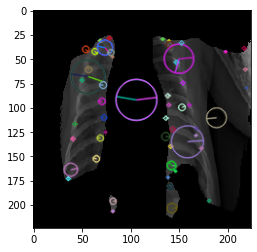

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 528.86it/s]


In [ ]:
descriptors_float = descriptors.astype(float)

In [ ]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [ ]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 669.01it/s]


In [ ]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [ ]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [ ]:
im_features.shape

(279, 128)

In [ ]:
im_features.dtype

dtype('float32')

In [ ]:
Model_s = tf.keras.models.load_model("DenseNet201.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
img_data = preprocess_input(img_data)

In [ ]:
Pred_fc3 = Model_C.predict(img_data)

In [ ]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 85360.77it/s]


In [ ]:
feature_data.shape

(279, 384)

In [ ]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [ ]:
Model_n = tf.keras.models.load_model("DenseNet201_combined_SIFT.h5")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[89  0  2]
 [ 0 81 10]
 [ 2  8 87]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        91
           1       0.91      0.89      0.90        91
           2       0.88      0.90      0.89        97

    accuracy                           0.92       279
   macro avg       0.92      0.92      0.92       279
weighted avg       0.92      0.92      0.92       279



#### ML Techniques

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [ ]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [ ]:
new_test_x = Model_csn.predict(x_new_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [ ]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[88  1  2]
 [ 0 79 12]
 [ 2  8 87]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        91
           1       0.90      0.87      0.88        91
           2       0.86      0.90      0.88        97

    accuracy                           0.91       279
   macro avg       0.91      0.91      0.91       279
weighted avg       0.91      0.91      0.91       279



xg_boost

In [ ]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[89  0  2]
 [ 0 80 11]
 [ 3  8 86]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        91
           1       0.91      0.88      0.89        91
           2       0.87      0.89      0.88        97

    accuracy                           0.91       279
   macro avg       0.92      0.91      0.91       279
weighted avg       0.91      0.91      0.91       279



random forest

In [ ]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[89  0  2]
 [ 0 81 10]
 [ 2  8 87]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        91
           1       0.91      0.89      0.90        91
           2       0.88      0.90      0.89        97

    accuracy                           0.92       279
   macro avg       0.92      0.92      0.92       279
weighted avg       0.92      0.92      0.92       279



### BRISK

In [ ]:
import cv2

In [ ]:
brisk = cv2.BRISK_create(50)
des_list = []

In [ ]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:00<00:00, 307.48it/s]


In [ ]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

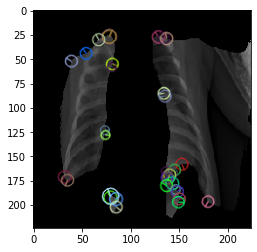

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 4549.10it/s]


In [ ]:
descriptors_float = descriptors.astype(float)

In [ ]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [ ]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 1040.02it/s]


In [ ]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [ ]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [ ]:
im_features.shape

(279, 128)

In [ ]:
im_features.dtype

dtype('float32')

In [ ]:
Model_s = tf.keras.models.load_model("DenseNet201.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
img_data = preprocess_input(img_data)

In [ ]:
Pred_fc3 = Model_C.predict(img_data)

In [ ]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 44240.70it/s]


In [ ]:
feature_data.shape

(279, 384)

In [ ]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [ ]:
Model_n = tf.keras.models.load_model("DenseNet201_combined_BRISK.h5")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[90  0  1]
 [ 1 82  8]
 [ 3  8 86]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        91
           1       0.91      0.90      0.91        91
           2       0.91      0.89      0.90        97

    accuracy                           0.92       279
   macro avg       0.92      0.93      0.92       279
weighted avg       0.92      0.92      0.92       279



#### ML Techniques

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [ ]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [ ]:
new_test_x = Model_csn.predict(x_new_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [ ]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[89  0  2]
 [ 0 81 10]
 [ 2  8 87]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        91
           1       0.91      0.89      0.90        91
           2       0.88      0.90      0.89        97

    accuracy                           0.92       279
   macro avg       0.92      0.92      0.92       279
weighted avg       0.92      0.92      0.92       279



xg_boost

In [ ]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[88  0  3]
 [ 1 82  8]
 [ 3  8 86]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        91
           1       0.91      0.90      0.91        91
           2       0.89      0.89      0.89        97

    accuracy                           0.92       279
   macro avg       0.92      0.92      0.92       279
weighted avg       0.92      0.92      0.92       279



random forest

In [ ]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[89  0  2]
 [ 0 81 10]
 [ 3  8 86]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        91
           1       0.91      0.89      0.90        91
           2       0.88      0.89      0.88        97

    accuracy                           0.92       279
   macro avg       0.92      0.92      0.92       279
weighted avg       0.92      0.92      0.92       279

